In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

In [76]:
# Load three years of data
df_load_2013 = pd.read_csv('./test_simulink/E-load-2013.csv')
df_load_2014 = pd.read_csv('./test_simulink/E-load-2014.csv')
df_load_2015 = pd.read_csv('./test_simulink/E-load-2015.csv')
df_weather_2013 = pd.read_csv('./test_simulink/E-2013.csv')
df_weather_2014 = pd.read_csv('./test_simulink/E-2014.csv')
df_weather_2015 = pd.read_csv('./test_simulink/E-2015.csv')

df_load = pd.concat([df_load_2013, df_load_2014, df_load_2015])
df_weather = pd.concat([df_weather_2013, df_weather_2014, df_weather_2015])

In [77]:
# First column of df_load is a timestamp, second is load in Watts
# Columns: ['DD/MM/YYYY HH:MM', 'Load (Watt)']
# The data is minute-by-minute
df_load

,DD/MM/YYYY HH:MM,Load (Watt)
0,01/01/2013 00:00,38517
1,01/01/2013 00:01,38205
2,01/01/2013 00:02,38069
3,01/01/2013 00:03,37922
4,01/01/2013 00:04,37594
...,...,...
525595,31/12/2015 23:55,25102
525596,31/12/2015 23:56,24630
525597,31/12/2015 23:57,24144
525598,31/12/2015 23:58,23993


In [78]:
# Columns: local_time_no_dst	wind_speed	irradiance_direct	irradiance_diffuse	temperature	irradiance_total
# The data is hour-by-hour
df_weather['irradiance_total'] = df_weather['irradiance_direct'] + df_weather['irradiance_diffuse']

In [79]:
# Change the time column names
df_weather['timestamp'] = df_weather['local_time_no_dst']
df_weather = df_weather.drop(columns=['local_time_no_dst'])

df_load['timestamp'] = df_load['DD/MM/YYYY HH:MM']
df_load = df_load.drop(columns=['DD/MM/YYYY HH:MM'])

# Convert to datetime
df_load['timestamp'] = pd.to_datetime(df_load['timestamp'], format='%d/%m/%Y %H:%M')
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], format='%Y-%m-%d %H:%M:%S')
# Set timestamp as index
df_load = df_load.set_index('timestamp')
df_weather = df_weather.set_index('timestamp')

# df_load columns are now: ['Load (Watt)']
# df_weather columns are now: ['wind_speed', 'irradiance_direct', 'irradiance_diffuse', 'temperature', 'irradiance_total']

In [80]:
df_load['Load (kW)'] = df_load['Load (Watt)'] / 1000
# This is sorta the same as taking the mean of the load over the hour
df_load_copy = df_load.copy()
df_load_copy['kwh_per_minute'] = df_load_copy['Load (kW)'] / 60
num_of_years = 3
num_of_households = 160

average_annual_energy = df_load_copy['kwh_per_minute'].sum() / num_of_years
average_annual_energy
average_annual_energy_per_household = average_annual_energy / num_of_households

print("Average annual energy consumption per household: " + str(average_annual_energy_per_household) + " kWh")
print("Average annual energy consumption for all households: " + str(average_annual_energy) + " kWh")

Average annual energy consumption per household: 2323.436003506945 kWh
Average annual energy consumption for all households: 371749.7605611112 kWh


In [81]:
# Ensure timestamps are sorted
df_load = df_load.sort_values(by='timestamp')
df_weather = df_weather.sort_values(by='timestamp')

In [82]:
class WindTurbine:
    """
    A class to model a wind turbine's power output characteristics.
    
    Attributes:
    blade_radius (float): Blade radius in meters [m].
    performance_coefficient (float): Performance coefficient, no unit [-].
    air_density (float): Air density in kilograms per cubic meter [kg/m^3].
    nominal_power (float): Nominal power output in kilowatts [kW].
    nominal_wind_speed (float): Wind speed at which turbine reaches nominal power [m/s].
    cut_out_speed (float): Wind speed at which turbine shuts down to prevent damage [m/s].
    cut_in_speed (float): Minimum wind speed required for power generation [m/s].
    """
    
    def __init__(self, blade_radius, performance_coefficient, air_density, 
                 nominal_power, nominal_wind_speed, cut_out_speed, cut_in_speed, price = None, lifetime = None, height = None):
        self.blade_radius = blade_radius
        self.performance_coefficient = performance_coefficient
        self.air_density = air_density
        self.nominal_power = nominal_power
        self.nominal_wind_speed = nominal_wind_speed
        self.cut_out_speed = cut_out_speed
        self.cut_in_speed = cut_in_speed
        self.price = price # in EUR
        self.lifetime = lifetime # in years
        self.height = height # in meters
    
    def get_power_simple(self, wind_speeds):
        """
        Calculate the power output profile of the wind turbine using a simplified version of the
        actual power curve.
        
        Parameters:
        wind_speeds (numpy.array): An array of wind speeds in meters per second [m/s].
        
        Returns:
        numpy.array: An array of power outputs in kilowatts [kW].
        """
        # Using piecewise to define the power output for different wind speed segments
        power_output = np.piecewise(wind_speeds,
            [wind_speeds < self.cut_in_speed,
                (wind_speeds >= self.cut_in_speed) & (wind_speeds <= self.nominal_wind_speed),
                (wind_speeds > self.nominal_wind_speed) & (wind_speeds < self.cut_out_speed),
                wind_speeds >= self.cut_out_speed],
            [0,
                lambda x: (x / self.nominal_wind_speed)**3 * self.nominal_power,
                self.nominal_power,
                0])
        return power_output
    
    def get_power_physical(self, wind_speeds):
        """
        Calculate the power output profile of the wind turbine using physical properties.
        
        Parameters:
        wind_speeds (numpy.array): An array of wind speeds in meters per second [m/s].
        
        Returns:
        numpy.array: An array of power outputs in kilowatts [kW].
        """
        # Calculate the area of the circle the blades cover
        area = np.pi * self.blade_radius**2
        
        # Calculate the power using the formula:
        # P = 0.5 * cp * rho * A * V^3
        # Where P is the power in watts, cp is the performance coefficient,
        # rho is the air density, A is the swept area of the blades, and
        # V is the wind speed in m/s.
        power_output = 0.5 * self.performance_coefficient * self.air_density * area * wind_speeds**3
        
        # Convert watts to kilowatts
        power_output /= 1000
        
        # Apply cut-in and cut-out speeds
        power_output = np.where(
            (wind_speeds >= self.cut_in_speed) & (wind_speeds < self.cut_out_speed),
            power_output,
            0
        )
        
        # Limit power to nominal power
        power_output = np.where(
            power_output > self.nominal_power,
            self.nominal_power,
            power_output
        )
        
        return power_output
    
    def get_capacity_factor(self, wind_speeds, years, simple = True):
        """
        Calculate the capacity factor of the wind turbine. Defaults to using the simple
        
        Parameters:
        wind_speeds (numpy.array): An array of wind speeds in meters per second [m/s].
        years (int): The number of years to calculate the capacity factor over.
        
        Returns:
        float: The capacity factor as a percentage [%].
        """
        # Calculate the power output profile in kilowatts [kW]
        if simple:
            power_output = self.get_power_simple(wind_speeds)
        else:
            power_output = self.get_power_physical(wind_speeds)

        # Calculate the number of hours in a year
        hours_per_year = 365 * 24
        
        # Wind speed is sampled hourly, so each element in power_output represents kilowatt-hours [kWh]
        # Calculate the capacity factor as a percentage [%]
        capacity_factor = (power_output.sum() / (self.nominal_power * years * hours_per_year)) * 100
        
        return capacity_factor
    
    def plot_simple_power_curve(self):
        """
        Plot the power output vs wind speed curve using the simplified method.
        Parameters: None
        Returns:
        None
        """
        # Generate wind speeds from 0 to a bit beyond the cut-out speed
        wind_speeds = np.linspace(0, self.cut_out_speed + 5, num=1000)
        # Initialize the power output array
        power_output_to_plot = self.get_power_simple(wind_speeds)

        # Plot the power curve
        plt.figure(figsize=(16, 10))
        plt.plot(wind_speeds, power_output_to_plot, label='Wind Turbine Power Curve')
        plt.axhline(y=self.nominal_power, color='r', linestyle='--', alpha = 0.33, label='Nominal Power')
        plt.axvline(x=self.cut_in_speed, color='g', linestyle='--', label='Cut-in Speed')
        
        plt.axvline(x=self.nominal_wind_speed, color='orange', linestyle='--', label='Nominal Wind Speed')
        plt.axvline(x=self.cut_out_speed, color='b', linestyle='--', label='Cut-out Speed')
        plt.title('Wind Turbine Power Output (Simple cubic) vs. Wind Speed')
        plt.xlabel('Wind Speed (m/s)')
        plt.ylabel('Power Output (kW)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_physical_power_curve(self):
        """
        Plot the power output vs wind speed curve using the physical method.
        Parameters: None
        Returns:
        None
        """
        # Generate wind speeds from 0 to a bit beyond the cut-out speed
        wind_speeds = np.linspace(0, self.cut_out_speed + 5, num=1000)
        # Initialize the power output array
        power_output_to_plot = self.get_power_physical(wind_speeds)

        # Plot the power curve
        plt.figure(figsize=(16, 10))
        plt.plot(wind_speeds, power_output_to_plot, label='Wind Turbine Power Curve')
        plt.axhline(y=self.nominal_power, color='r', linestyle='--', alpha = 0.33, label='Nominal Power')
        plt.axvline(x=self.cut_in_speed, color='g', linestyle='--', label='Cut-in Speed')

        plt.axvline(x=self.nominal_wind_speed, color='orange', linestyle='--', label='Nominal Wind Speed')
        plt.axvline(x=self.cut_out_speed, color='b', linestyle='--', label='Cut-out Speed')
        plt.title('Wind Turbine Power Output (Physical) vs. Wind Speed')
        plt.xlabel('Wind Speed (m/s)')
        plt.ylabel('Power Output (kW)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def get_annual_energy_production(self, wind_speeds, years, simple = True):
        """
        Calculate the total average annual energy production from data of possibly multiple years. 
        
        Parameters:
        wind_speeds (numpy.array): An array of hourly wind speeds in meters per second [m/s].
        years (int): Period of data
        
        Returns:
        float: The annual energy production in kilowatt-hours [kWh].
        """
        # Calculate the power output profile in kilowatts [kW]
        if simple:
            power_output = self.get_power_simple(wind_speeds)
        else:
            power_output = self.get_power_physical(wind_speeds)

        # Power output is in kilowatts [kW] and it is hourly, therefore the same as kilowatt-hours [kWh]
        
        total_energy_production = power_output.sum()
        average_annual_total_energy_production = total_energy_production / years
        return average_annual_total_energy_production


In [83]:
class WindFarm:
    """
    A class that contains multiple wind turbines.
    Attributes:
    turbines (list): A list of WindTurbine objects.
    """

    def __init__(self, turbines):
        self.turbines = turbines

    def get_power_output_simple(self, wind_speeds):
        """
        Calculate the total power output profile of the wind farm using a simple cubic formula.
        Parameters:
        wind_speeds (numpy.array): An array of wind speeds in meters per second [m/s].
        Returns:
        numpy.array: An array of power outputs in kilowatts [kW].
        """
        # wind_speeds is a DataFrame, convert to numpy array
        if type(wind_speeds) == pd.core.frame.DataFrame:
            wind_speeds = wind_speeds.to_numpy()
        power_output = np.zeros(len(wind_speeds))
        for turbine in self.turbines:
            power_output += turbine.get_power_simple(wind_speeds)
        return power_output

    def get_power_output_physical(self, wind_speeds):
        """
        Calculate the total power output profile of the wind farm using physical properties.
        Parameters:
        wind_speeds (numpy.array): An array of wind speeds in meters per second [m/s].
        Returns:
        numpy.array: An array of power outputs in kilowatts [kW].
        """
        # wind_speeds is a DataFrame, convert to numpy array
        if type(wind_speeds) == pd.core.frame.DataFrame:
            wind_speeds = wind_speeds.to_numpy()
        power_output = np.zeros(len(wind_speeds))
        for turbine in self.turbines:
            power_output += turbine.get_power_physical(wind_speeds)
        return power_output
    
    def get_capacity_factor(self, wind_speeds, years, simple = True):
        """
        Calculate the capacity factor of the wind farm.
        Parameters:
        wind_speeds (numpy.array): An array of wind speeds in meters per second [m/s].
        years (int): The number of years to calculate the capacity factor over.
        Returns:
        float: The capacity factor as a percentage [%].
        """
        if simple:
            power_output = self.get_power_output_simple(wind_speeds)
        else:
            power_output = self.get_power_output_physical(wind_speeds)
        
        # Wind speed is sampled hourly, so each element in power_output represents kilowatt-hours [kWh]
        wind_farm_energy_produced = power_output.sum()
        wind_farm_total_nominal_power = np.sum([turbine.nominal_power for turbine in self.turbines])

        # Calculate the number of hours in a year
        hours_per_year = 365 * 24
        
        # Calculate the capacity factor as a percentage [%]
        capacity_factor = (wind_farm_energy_produced / (wind_farm_total_nominal_power * years * hours_per_year)) * 100
        return capacity_factor
    
    def get_annual_energy_production(self, wind_speeds, years, simple = True):
        """
        Calculate the total average annual energy production from data of possibly multiple years. 
        
        Parameters:
        wind_speeds (numpy.array): An array of hourly wind speeds in meters per second [m/s].
        years (int): Period of data
        
        Returns:
        float: The annual energy production in kilowatt-hours [kWh].
        """
        if simple:
            power_output = self.get_power_output_simple(wind_speeds)
        else:
            power_output = self.get_power_output_physical(wind_speeds)


        # Power output is in kilowatts [kW] and it is hourly, therefore the same as kilowatt-hours [kWh]
        total_energy_production = power_output.sum()
        average_annual_total_energy_production = total_energy_production / years
        return average_annual_total_energy_production
    

In [84]:
class WindFarmBuilder:
    """
    Produces WindFarm objects.
    """
    def __init__(self):
        pass
    
    # This function takes a list of wind turbines and a list of quantities of each turbine
    def build_wind_farm(self, list_of_wind_turbines, list_of_quantities):
        """
        Build a wind farm from a list of wind turbines and a list of quantities of each turbine.
        Parameters:
        list_of_wind_turbines (list): A list of WindTurbine objects.
        list_of_quantities (list): A list of integers representing the number of each turbine in the wind farm.
        Returns:
        WindFarm: A WindFarm object.
        """
        # Initialize an empty list of turbines
        wind_farm_turbines = []
        
        # For each turbine type and quantity
        for turbine, quantity in zip(list_of_wind_turbines, list_of_quantities):
            # Add the turbine to the list of turbines the wind farm will have
            wind_farm_turbines += [turbine] * quantity
        
        # Create a wind farm from the list of turbines
        wind_farm = WindFarm(wind_farm_turbines)
        
        return wind_farm


5.3491759101282685
13.384548422073706
Capacity factor, simple:  26.745879550641344
Capacity factor, physical:  66.92274211036853
Capacity factor, wind turbine, simple:  26.745879550641344
Capacity factor, wind turbine, physical:  66.92274211036853


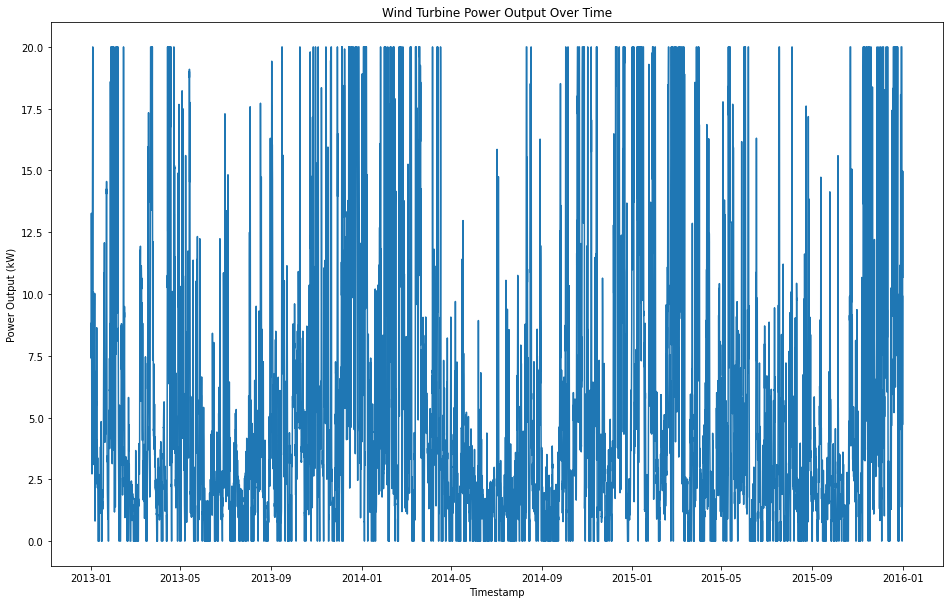

In [85]:
turbine = WindTurbine(
    blade_radius=5,  # Urban wind turbine size [m]
    performance_coefficient=16/27,  # From matlab [-]
    air_density=1.225,  # For air at sea level [kg/m^3]
    nominal_power=20,  # From matlab [kW]
    nominal_wind_speed=15,  # From matlab [m/s]
    cut_out_speed=25,  # From matlab [m/s]
    cut_in_speed=5,  # From matlab [m/s]
)
example_turbine = turbine
turbine_power_output_simple = turbine.get_power_simple(df_weather['wind_speed'].to_numpy())
turbine_power_output_physical = turbine.get_power_physical(df_weather['wind_speed'].to_numpy())

print(np.mean(turbine_power_output_simple))
print(np.mean(turbine_power_output_physical))

print('Capacity factor, simple: ', turbine.get_capacity_factor(df_weather['wind_speed'].to_numpy(), years=3))
print('Capacity factor, physical: ', turbine.get_capacity_factor(df_weather['wind_speed'].to_numpy(), years=3, simple=False))

# Create a wind farm with 1 turbine
wind_farm = WindFarm([turbine])
print('Capacity factor, wind turbine, simple: ' , wind_farm.get_capacity_factor(df_weather['wind_speed'].to_numpy(), years=3))
print('Capacity factor, wind turbine, physical: ' , wind_farm.get_capacity_factor(df_weather['wind_speed'].to_numpy(), years=3, simple=False))

# Plot turbine power_output vs time
plt.figure(figsize=(16, 10))
plt.plot(df_weather.index, turbine_power_output_simple)
plt.title('Wind Turbine Power Output Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Power Output (kW)')
plt.show()

Average annual energy production:  253138.29714566955 kWh
Capacity factor:  57.7941317684177 %


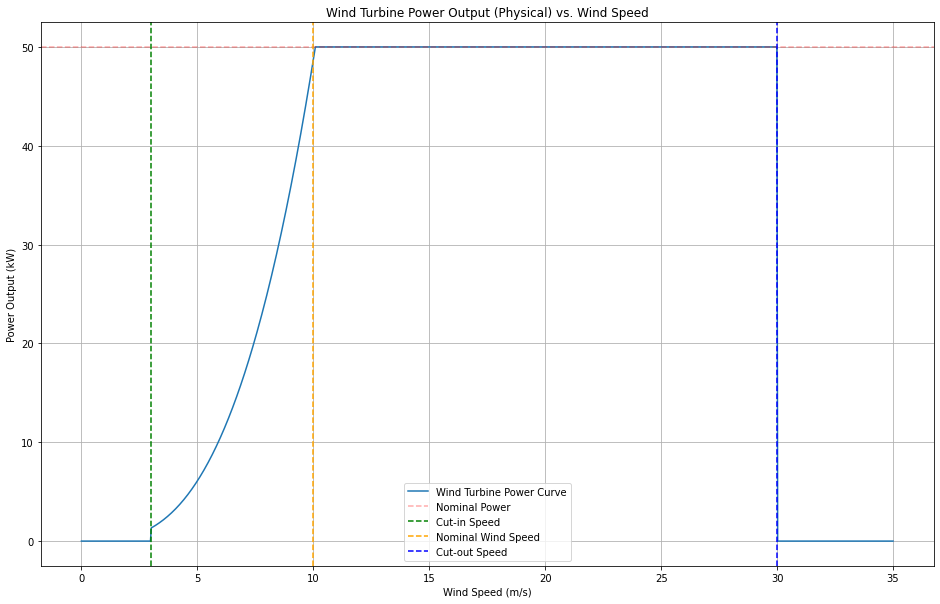

In [86]:
# Initialize the WindTurbine object
flexpro_turbine = WindTurbine(blade_radius=7.5, # [m]
                              performance_coefficient=0.45, # [-]
                              air_density=1.225, # [kg/m^3]
                              nominal_power=50, # [kW] 
                              nominal_wind_speed=10, # [m/s]
                              cut_out_speed=30, # [m/s] 
                              cut_in_speed=3, # [m/s] 
                              price=68000, # EUR 
                              lifetime=25, # years 
                              height=18) # [m]
# Print average annual energy production
print('Average annual energy production: ', flexpro_turbine.get_annual_energy_production(df_weather['wind_speed'].to_numpy(), years=3, simple=False), 'kWh')
# Print capacity factor
print('Capacity factor: ', flexpro_turbine.get_capacity_factor(df_weather['wind_speed'].to_numpy(), years=3, simple=False), '%')
# Plot power curve
flexpro_turbine.plot_physical_power_curve()

In [87]:
df_load_hourly = df_load.resample('H').mean()
df_load_hourly_2013 = df_load_hourly.loc['2013-01-01':'2013-12-31']
df_load_hourly_2014 = df_load_hourly.loc['2014-01-01':'2014-12-31']
df_load_hourly_2015 = df_load_hourly.loc['2015-01-01':'2015-12-31']
df_weather_hourly_2013 = df_weather.loc['2013-01-01':'2013-12-31']
df_weather_hourly_2014 = df_weather.loc['2014-01-01':'2014-12-31']
df_weather_hourly_2015 = df_weather.loc['2015-01-01':'2015-12-31']

2013 total energy consumption: 371.66154376666674 MWh
Capacity factor, mixed wind farm, simple:  16.54148645476344
Capacity factor, mixed wind farm, physical:  18.8753004098517
Annual energy production, mixed wind farm, simple:  373.85082706681754 MWh


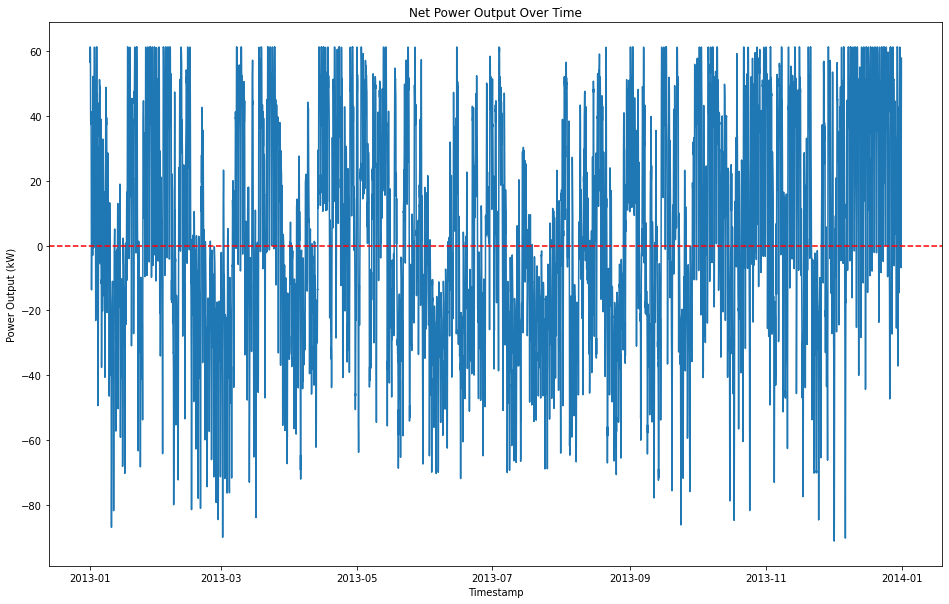

Generated energy wasted:  153600.44396703911 kWh
Energy needed from grid:  98665.09823072953 kWh


In [88]:
gazelle_turbine = WindTurbine(blade_radius=5, # [m]
                              performance_coefficient=0.4, # [-]
                              air_density=1.225, # [kg/m^3]
                              nominal_power=20, # [kW] 
                              nominal_wind_speed=13, # [m/s]
                              cut_out_speed=20, # [m/s] 
                              cut_in_speed=4, # [m/s] 
                              price=None, # EUR 
                              lifetime=22.5, # years 
                              height=18) # [m]

aircon_hawt_turbine = WindTurbine(blade_radius=3.5, # [m]
                              performance_coefficient=0.35, # [-]
                              air_density=1.225, # [kg/m^3]
                              nominal_power=10, # [kW] 
                              nominal_wind_speed=11, # [m/s]
                              cut_out_speed=32, # [m/s] 
                              cut_in_speed=2.5, # [m/s] 
                              price=None, # EUR 
                              lifetime=25, # years 
                              height=18) # [m]

travere_turbine = WindTurbine(blade_radius=1.6, # [m]
                              performance_coefficient=0.35, # [-]
                                air_density=1.225, # [kg/m^3]
                                nominal_power=1.6, # [kW]
                                nominal_wind_speed=10, # [m/s]
                                cut_out_speed=60, # [m/s]
                                cut_in_speed=2.5 , # [m/s]
                                price=None, # EUR
                                lifetime=25, # years
                                height=12) # [m]

print("2013 total energy consumption: " + str(df_load_hourly_2013['Load (kW)'].sum()/1000) + " MWh")
wf_builder = WindFarmBuilder()
example_mixed_wind_farm = wf_builder.build_wind_farm([gazelle_turbine, aircon_hawt_turbine, travere_turbine], [1, 5, 10])
print('Capacity factor, mixed wind farm, simple: ' , example_mixed_wind_farm.get_capacity_factor(df_weather_hourly_2013['wind_speed'].to_numpy(), years=3))
print('Capacity factor, mixed wind farm, physical: ' , example_mixed_wind_farm.get_capacity_factor(df_weather_hourly_2013['wind_speed'].to_numpy(), years=3, simple=False))
print('Annual energy production, mixed wind farm, simple: ' , example_mixed_wind_farm.get_annual_energy_production(df_weather_hourly_2013['wind_speed'].to_numpy(), years=1)/1000, "MWh")

def get_net_power(df_hourlyload_1year, df_weather_hourly_1year, windfarm, plot=False):
    """
    Calculates the net power output of a wind farm over a year.
    Parameters:
    df_hourlyload_1year (pandas.DataFrame): A DataFrame of hourly energy consumption in kW.
    df_weather_hourly_1year (pandas.DataFrame): A DataFrame of hourly weather data.
    windfarm (WindFarm): A WindFarm object.
    plot (bool): Whether to plot the power output over time.
    Returns:
    pandas.DataFrame: A DataFrame of net power output in kW.
    """
    # Calculate the power output of the wind farm
    power_output = windfarm.get_power_output_physical(df_weather_hourly_1year['wind_speed'].to_numpy())
    
    net_power = df_hourlyload_1year.copy()
    # Drop the load column
    net_power = net_power.drop(columns=['Load (Watt)'])
    # Add the power output column
    net_power['Power Output (kW)'] = power_output
    # Calculate the net power
    net_power['Net Power (kW)'] = net_power['Power Output (kW)'] - net_power['Load (kW)']

    if plot:
        # Plot the net power
        plt.figure(figsize=(16, 10))
        plt.plot(net_power.index, net_power['Net Power (kW)'])
        plt.title('Net Power Output Over Time')
        # Add 0 x-axis line
        plt.axhline(y=0, color='r', linestyle='--', alpha = 1)
        plt.xlabel('Timestamp')
        plt.ylabel('Power Output (kW)')
        plt.show()

    return net_power

net_power = get_net_power(df_load_hourly_2013, df_weather_hourly_2013, example_mixed_wind_farm, plot=True)

# Sum positive net power to get generated energy wasted
generated_energy_wasted = net_power[net_power['Net Power (kW)'] > 0]['Net Power (kW)'].sum()
# Sum negative net power to get energy needed from grid
energy_needed_from_grid = net_power[net_power['Net Power (kW)'] < 0]['Net Power (kW)'].sum()

# Print results
print('Generated energy wasted: ', generated_energy_wasted, 'kWh')
print('Energy needed from grid: ', abs(energy_needed_from_grid), 'kWh')

In [89]:
def simulate_energy_storage(df, storage_capacity_kWh):
    """
    Simulate the addition of an energy storage system to a dataset of power generation and consumption.

    Parameters:
    df (DataFrame): A DataFrame with columns 'Power Output (kW)', 'Load (kW)', 'Net Power (kW)' representing hourly data.
    storage_capacity_kWh (float): The capacity of the energy storage system in kWh.

    Returns:
    np.array: An array containing the new net power after considering the battery storage.
    """

    battery_state = 0  # Initial state of charge of the battery
    new_net_power = []

    for index, row in df.iterrows():
        net_energy = row['Net Power (kW)']  # Net power for the hour

        if net_energy > 0:  # Excess energy
            energy_to_charge = min(net_energy, storage_capacity_kWh - battery_state)
            battery_state += energy_to_charge
            new_net_power.append(net_energy - energy_to_charge)

        elif net_energy < 0:  # Energy deficit
            energy_to_discharge = min(-net_energy, battery_state)
            battery_state -= energy_to_discharge
            adjusted_net_energy = net_energy + energy_to_discharge
            new_net_power.append(adjusted_net_energy if adjusted_net_energy < 0 else 0)

    return np.array(new_net_power)

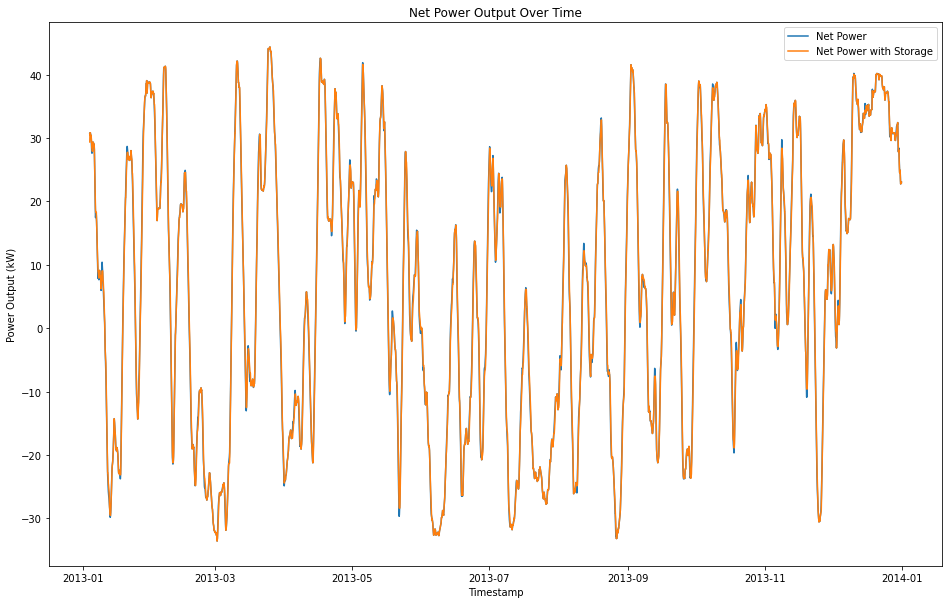

In [95]:
tesla_powerwall_capacity_kWh = 13.5
net_power['Net Power Storage (kW)'] = simulate_energy_storage(net_power, 100)

# Plot moving average of net power and net power with storage
plt.figure(figsize=(16, 10))
plt.plot(net_power.index, net_power['Net Power (kW)'].rolling(72).mean(), label='Net Power')
plt.plot(net_power.index, net_power['Net Power Storage (kW)'].rolling(72).mean(), label='Net Power with Storage')
plt.title('Net Power Output Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Power Output (kW)')
plt.legend()
plt.show()